Preparación del entorno

In [45]:
import numpy as np
import joblib
from envs.v2.multi_step_limited_attack_env import AttackEnvLimitedMultiStep
from stable_baselines3.common.callbacks import BaseCallback
from envs.v2.defender_env_2 import DefenderEnvV2
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3 import PPO, SAC
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

Funciones auxiliares

In [46]:
class DefenderLoggerCallback(BaseCallback):
    def __init__(self, log_freq: int = 1000, verbose: int = 0):
        super().__init__(verbose)
        self.log_freq = log_freq
        self.episode_count = 0

        # Buffers por ventana (1000 episodios)
        self.rewards_buffer = []          # Todas las recompensas de los pasos
        self.threshold_buffer = []        # Todos los thresholds vistos (valor umbral para decidir ataque)
        self.p_attack_buffer = []         # Todas las p_attack vistas (probabilidad de que la muestra sea de ataque según el modelo)

        # Contadores por ventana para calcular dection rate y false positive rate
        self.attack_count = 0             # Número de muestras de ataque
        self.tp_count = 0                 # Número de ataques correctamente detectados
        self.normal_count = 0             # Número de muestras normales
        self.fp_count = 0                 # Número de falsos positivos (normales mal clasificados como ataques) 

        # Históricos completos para graficar
        self.history_episodes = []
        self.history_mean_reward = []
        self.history_detection_rate = []      # Ratio de verdaderos positivos tp (numeros de ataques detectados) / ataques totales
        self.history_false_positive_rate = [] # Ratio de falsos positivos fp (normales mal clasificados) / normales totales
        self.history_mean_threshold = []
        self.history_mean_p_attack = []

    def _on_step(self) -> bool:
       
        # Extraemos la información relevante del entorno
        infos = self.locals["infos"]
        rewards = self.locals["rewards"]
        dones = self.locals["dones"]

        # Itreramos sobre la informacióm, recompensa y done de cada entorno en cada paso
        for info, r, done in zip(infos, rewards, dones):

            # Guardamos recompensa de este paso
            self.rewards_buffer.append(float(r))

            # Extraemos info del entorno si está disponible
            if isinstance(info, dict):

                # Guardamos threshold
                if "threshold" in info:
                    self.threshold_buffer.append(float(info["threshold"]))

                # Guardamos p_attack
                if "p_attack" in info:
                    self.p_attack_buffer.append(float(info["p_attack"]))

                # Si tenemos la etiqueta real y la predicción, actualizamos contadores
                if "y_sample" in info and "pred" in info:
                    y = int(info["y_sample"])   # 0 = normal, 1 = ataque
                    pred = int(info["pred"])    # 0 = normal, 1 = ataque

                    # Si es ataque o normal, actualizamos contadores
                    if y == 1:
                        self.attack_count += 1
                        if pred == 1:
                            self.tp_count += 1
                    else:
                        self.normal_count += 1
                        if pred == 1:
                            self.fp_count += 1

            # Si termina episodio
            if done:
                self.episode_count += 1

                # Cada log_freq episodios, calculamos métricas y reseteamos buffers
                if self.episode_count > 0 and self.episode_count % self.log_freq == 0:

                    # Reward media por paso en la ventana
                    mean_reward = np.mean(self.rewards_buffer) if self.rewards_buffer else 0.0

                    # Tasa de detección (TPR) y tasa de falsos positivos (FPR)
                    detection_rate = (self.tp_count / self.attack_count) if self.attack_count > 0 else 0.0
                    false_positive_rate = (self.fp_count / self.normal_count) if self.normal_count > 0 else 0.0

                    # Stats de threshold y p_attack
                    mean_threshold = np.mean(self.threshold_buffer) if self.threshold_buffer else 0.0
                    mean_p_attack = np.mean(self.p_attack_buffer) if self.p_attack_buffer else 0.0

                    # Guardamos en históricos
                    self.history_episodes.append(self.episode_count)
                    self.history_mean_reward.append(mean_reward)
                    self.history_detection_rate.append(detection_rate)
                    self.history_false_positive_rate.append(false_positive_rate)
                    self.history_mean_threshold.append(mean_threshold)
                    self.history_mean_p_attack.append(mean_p_attack)

                    # Log por consola
                    print(
                        f"[DefenderLogger] Episodios: {self.episode_count:6d} | "
                        f"Reward media: {mean_reward: .3f} | "
                        f"TPR (detección ataques): {detection_rate*100:5.1f}% | "
                        f"FPR (falsos positivos): {false_positive_rate*100:5.1f}% | "
                        f"threshold medio: {mean_threshold: .3f} | "
                        f"p_attack media: {mean_p_attack: .3f}"
                    )

                    # Reseteamos buffers para la siguiente ventana
                    self.rewards_buffer.clear()
                    self.threshold_buffer.clear()
                    self.p_attack_buffer.clear()
                    self.attack_count = 0
                    self.tp_count = 0
                    self.normal_count = 0
                    self.fp_count = 0

        return True

In [47]:
# Función de evaluación del defensor
def evaluate_defender(model, env, n_episodes=500):

    # Inicializamos contadores
    total_reward = 0.0
    total_steps = 0
    attack_count = 0
    detected_attacks = 0   # TP
    normal_count = 0
    false_positives = 0    # FP
    thresholds = []
    p_attacks = []

    # Reset inicial del entorno vectorizado
    obs = env.reset()

    # Iteramos sobre el número de episodios a evaluar
    for _ in range(n_episodes):

        # Variables de control de finalización del episodio
        done = False
        truncated = False

        # Mientras no termine el episodio
        while not (done or truncated):
            # Acción del modelo (determinista en evaluación)
            action, _ = model.predict(obs, deterministic=True)

            # Step en el entorno vectorizado
            obs, rewards, dones, infos = env.step(action)

            # Cargamos la información relevante del primer entorno
            r = float(rewards[0])
            info0 = infos[0]
            done = bool(dones[0])

            # Parche para gym
            truncated = info0.get("terminal_observation") is not None if False else False

            # Acumulamos recompensa y pasos
            total_reward += r
            total_steps += 1

            # Extraemos threshold y p_attack si están
            if "threshold" in info0:
                thresholds.append(float(info0["threshold"]))
            if "p_attack" in info0:
                p_attacks.append(float(info0["p_attack"]))

            # Extraemos y_sample y pred para TP / FP
            if "y_sample" in info0 and "pred" in info0:
                y = int(info0["y_sample"])   # 0 = normal, 1 = ataque
                pred = int(info0["pred"])    # 0 = normal, 1 = ataque

                # Si es ataque o normal, actualizamos contadores
                if y == 1:
                    attack_count += 1
                    if pred == 1:
                        detected_attacks += 1
                else:
                    normal_count += 1
                    if pred == 1:
                        false_positives += 1

        # Reset para siguiente episodio
        obs = env.reset()

    # Cálculo de métricas
    mean_reward = total_reward / total_steps if total_steps > 0 else 0.0
    detection_rate = detected_attacks / attack_count if attack_count > 0 else 0.0
    false_positive_rate = false_positives / normal_count if normal_count > 0 else 0.0
    mean_threshold = float(np.mean(thresholds)) if thresholds else None
    mean_p_attack = float(np.mean(p_attacks)) if p_attacks else None

    # Retornamos métricas
    return detection_rate, false_positive_rate, mean_reward, mean_threshold, mean_p_attack


In [48]:
# Función para muestrear episodios del defensor y extraer datos
def sample_defender_episodes(model, env, n_episodes=200):

    # Listas para almacenar datos   
    xs = []
    ys = []
    preds = []
    thresholds = []
    p_attacks = []
    rewards = []
    correct_flags = []
    episode_ids = []

    # Reset inicial
    obs = env.reset()

    # Iteramos sobre episodios
    for ep in range(n_episodes):

        # Variables de control de finalización del episodio 
        done = False
        truncated = False

        # Iteramos sobre pasos dentro del episodio a muestrear
        while not (done or truncated):

            # Obtenemos la acción del agente (determinística)
            action, _ = model.predict(obs, deterministic=True)

            # Ejecutamos la acción en el entorno y obtenemos los resultados
            obs, rs, dones, infos = env.step(action)

            # Cogemos la información del primer entorno (vectorizado, solo hay uno)
            r = float(rs[0])
            info0 = infos[0]
            done = bool(dones[0])

            # Extraemos info relevante si está disponible
            x_sample = info0.get("x_sample", None)
            y_sample = info0.get("y_sample", None)
            pred = info0.get("pred", None)
            th = info0.get("threshold", None)
            p_att = info0.get("p_attack", None)

            # Solo guardamos si tenemos al menos x_sample, y_sample y pred
            if x_sample is not None and y_sample is not None and pred is not None:
                xs.append(np.array(x_sample, dtype=np.float32))
                ys.append(int(y_sample))
                preds.append(int(pred))
                thresholds.append(float(th) if th is not None else np.nan)
                p_attacks.append(float(p_att) if p_att is not None else np.nan)
                rewards.append(r)
                correct_flags.append(1 if int(pred) == int(y_sample) else 0)
                episode_ids.append(ep)

        # Siguiente episodio
        obs = env.reset()

    # Convertimos a arrays numpy
    xs = np.vstack(xs) if len(xs) > 0 else np.empty((0, 2), dtype=np.float32)
    ys = np.array(ys, dtype=np.int32)
    preds = np.array(preds, dtype=np.int32)
    thresholds = np.array(thresholds, dtype=np.float32)
    p_attacks = np.array(p_attacks, dtype=np.float32)
    rewards = np.array(rewards, dtype=np.float32)
    correct_flags = np.array(correct_flags, dtype=np.int32)
    episode_ids = np.array(episode_ids, dtype=np.int32)

    # Retornamos los datos muestreados
    return xs, ys, preds, thresholds, p_attacks, rewards, correct_flags, episode_ids

Creación del área de trabajo

In [49]:
# Cargar datos
data = np.load("../../data/v2/synthetic_2d.npz")
X_train, X_test = data["X_train"], data["X_test"]
y_train, y_test = data["y_train"], data["y_test"]

# Cargamos las muestras normales y de ataque
normal_samples = X_train[y_train == 0]
attack_samples = X_train[y_train == 1]

# Imprimir formas de los datos cargados
print("Normal:", normal_samples.shape, "Attack:", attack_samples.shape)

Normal: (800, 2) Attack: (800, 2)


In [50]:
# Cargar clasificador clásico
clf = joblib.load("../../classifiers/v2/logreg_synthetic_2d.joblib")

# Crear AttackEnvLimitedMultiStep igual que lo hicmos para entrenar SAC
attack_env = AttackEnvLimitedMultiStep(
    attack_samples=attack_samples,
    clf=clf,
    threshold=0.5,   # Este threshold solo afecta a la reward del atacante, no al defensor
    epsilon=0.7,
    penalty=0.01,
    max_steps=5,
)

# Cargar modelo SAC atacante
attacker_model = SAC.load("../../agents/v2/sac_attacker_limited_multistep")

In [51]:
# Función para crear el entorno del defensor
def make_defender_env():
    return DefenderEnvV2(
        normal_samples=normal_samples,
        attack_env=attack_env,
        attacker_model=attacker_model,

        # Parámetros principales
        init_threshold=0.5,
        delta_max=0.05,
        min_threshold=0.2,
        max_threshold=0.8,

        # Probabilidad de ataque (escenario realista)
        attack_prob=0.3,

        # Longitud del episodio
        episode_length=50,

        # Penalizaciones importantes
        move_penalty=0.1,
        extreme_penalty=0.5,   # <-- ESTE ES EL NOMBRE CORRECTO

        # (Opcionales, puedes dejar los defaults)
        fn_penalty=-4.0,
        fp_penalty=-3.0,
        tp_reward=2.0,
        tn_reward=1.0,
    )

# Crear entorno vectorizado para el defensor
venv_def = DummyVecEnv([make_defender_env])

# Norma
venv_def = VecNormalize(venv_def, norm_obs=True, norm_reward=False)

Entrenamiento del agente PPO Defender

In [52]:
# Arquitectura de la red neuronal para el defensor
policy_kwargs = dict(net_arch=[128, 128])

model_defender = PPO(
    "MlpPolicy",
    venv_def,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=256,
    gae_lambda=0.95,
    gamma=0.99,
    n_epochs=10,
    clip_range=0.2,
    ent_coef=0.01,
    vf_coef=0.5,
    policy_kwargs=policy_kwargs,
    verbose=0
)

# Creación de callback personalizado para logging
defender_callback = DefenderLoggerCallback(log_freq=100)

# Entrenamiento del modelo del defensor
model_defender.learn(total_timesteps=100_000, callback=defender_callback)
# Guardar el modelo entrenado del defensor
model_defender.save("../../agents/v2/ppo_defender_threshold_2")

[DefenderLogger] Episodios:    100 | Reward media:  0.308 | TPR (detección ataques):  25.5% | FPR (falsos positivos):  25.3% | threshold medio:  0.495 | p_attack media:  0.258
[DefenderLogger] Episodios:    200 | Reward media:  0.335 | TPR (detección ataques):  25.0% | FPR (falsos positivos):  26.0% | threshold medio:  0.463 | p_attack media:  0.253
[DefenderLogger] Episodios:    300 | Reward media:  0.409 | TPR (detección ataques):  26.4% | FPR (falsos positivos):  25.9% | threshold medio:  0.429 | p_attack media:  0.252
[DefenderLogger] Episodios:    400 | Reward media:  0.357 | TPR (detección ataques):  27.4% | FPR (falsos positivos):  28.9% | threshold medio:  0.387 | p_attack media:  0.260
[DefenderLogger] Episodios:    500 | Reward media:  0.372 | TPR (detección ataques):  26.8% | FPR (falsos positivos):  28.1% | threshold medio:  0.388 | p_attack media:  0.258
[DefenderLogger] Episodios:    600 | Reward media:  0.382 | TPR (detección ataques):  27.3% | FPR (falsos positivos):  2

Gráficas PPO Defender

In [53]:
# Configuración de estilo
plt.style.use("seaborn-v0_8-whitegrid")

# Datos para graficar
episodes = np.array(defender_callback.history_episodes)

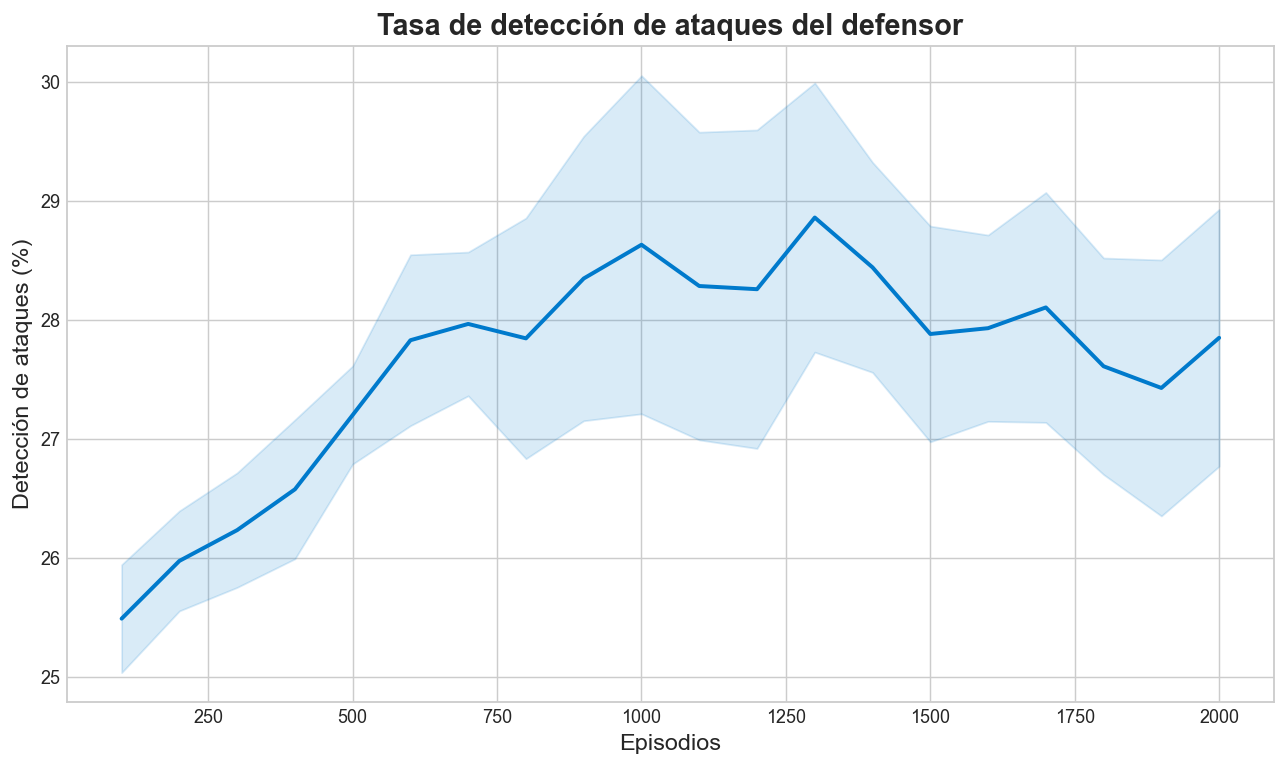

In [54]:
# Gráfico de Tasa de detección de ataques (TPR)
detection_rate = np.array(defender_callback.history_detection_rate) * 100

# Suavizado
window = 5
smooth_detection = uniform_filter1d(detection_rate, size=window)
mean = smooth_detection
std = uniform_filter1d(np.abs(detection_rate - mean), size=window)

# Configuración del gráfico
plt.figure(figsize=(10, 6), dpi=130)

# Línea suavizada
plt.plot(episodes, mean, linewidth=2.2, color="#007acc")

# Banda difuminada
plt.fill_between(
    episodes,
    mean - std,
    mean + std,
    color="#007acc",
    alpha=0.15
)
plt.title("Tasa de detección de ataques del defensor", fontsize=16, fontweight="bold")
plt.xlabel("Episodios", fontsize=13)
plt.ylabel("Detección de ataques (%)", fontsize=13)
plt.tight_layout()
plt.show()


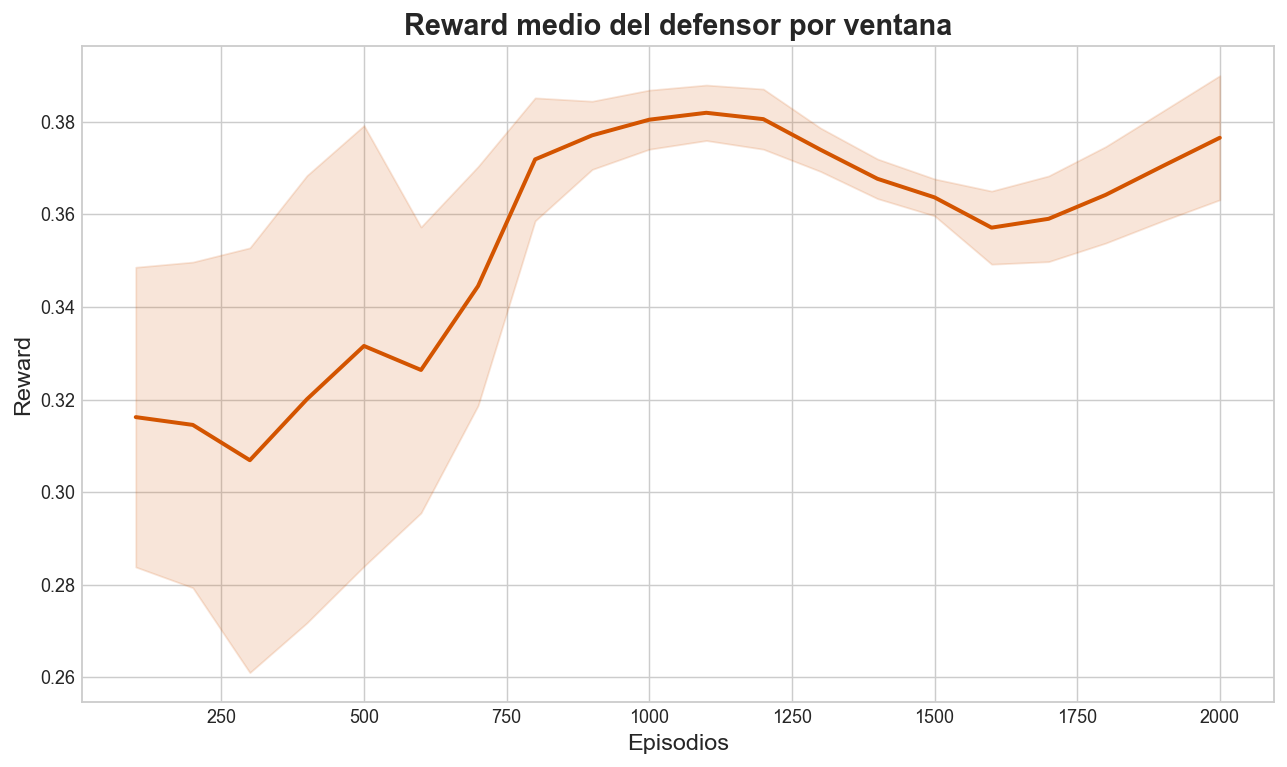

In [ ]:
# Reward medio por ventana
mean_reward = np.array(defender_callback.history_mean_reward)

# Suavizado
window = 5
smooth_reward = uniform_filter1d(mean_reward, size=window)

# Desviación estándar local
std_reward = uniform_filter1d(np.abs(mean_reward - smooth_reward), size=window)

# Configuración del gráfico
plt.figure(figsize=(10, 6), dpi=130)

# Línea suavizada
plt.plot(episodes, smooth_reward, linewidth=2.2, color="#d35400")

# Banda difuminada
plt.fill_between(
    episodes,
    smooth_reward - std_reward,
    smooth_reward + std_reward,
    color="#d35400",
    alpha=0.15
)

plt.title("Reward medio del defensor por ventana", fontsize=16, fontweight="bold")
plt.xlabel("Episodios", fontsize=13)
plt.ylabel("Reward", fontsize=13)
plt.tight_layout()
plt.show()

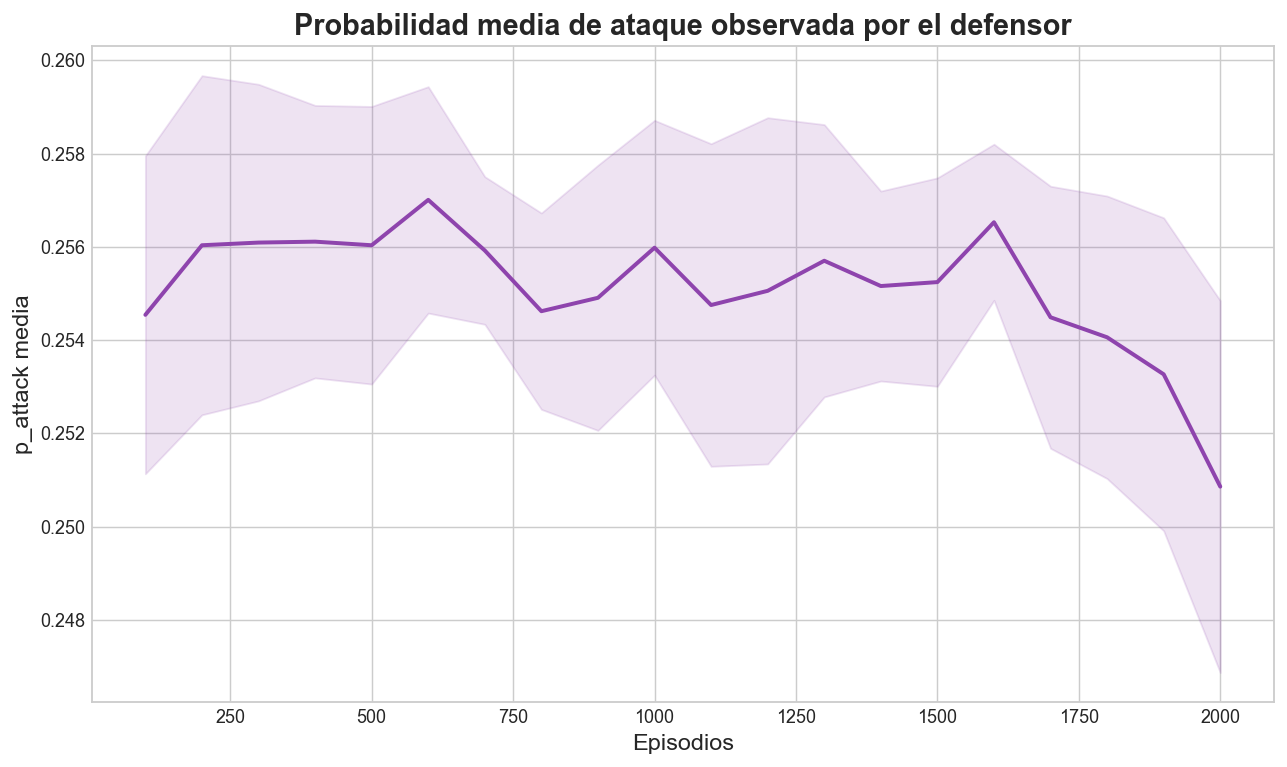

In [ ]:
# Probabilidad media de ataque (según el clasificador) que ve el defensor
mean_p_attack = np.array(defender_callback.history_mean_p_attack)

# Suavizado
window = 5
smooth_p_attack = uniform_filter1d(mean_p_attack, size=window)

# Desviación estándar local
std_p_attack = uniform_filter1d(np.abs(mean_p_attack - smooth_p_attack), size=window)

# Configuración del gráfico
plt.figure(figsize=(10, 6), dpi=130)

# Línea suavizada
plt.plot(episodes, smooth_p_attack, linewidth=2.2, color="#8e44ad")

# Banda difuminada
plt.fill_between(
    episodes,
    smooth_p_attack - std_p_attack,
    smooth_p_attack + std_p_attack,
    color="#8e44ad",
    alpha=0.15
)

plt.title("Probabilidad media de ataque observada por el defensor", fontsize=16, fontweight="bold")
plt.xlabel("Episodios", fontsize=13)
plt.ylabel("p_attack media", fontsize=13)
plt.tight_layout()
plt.show()


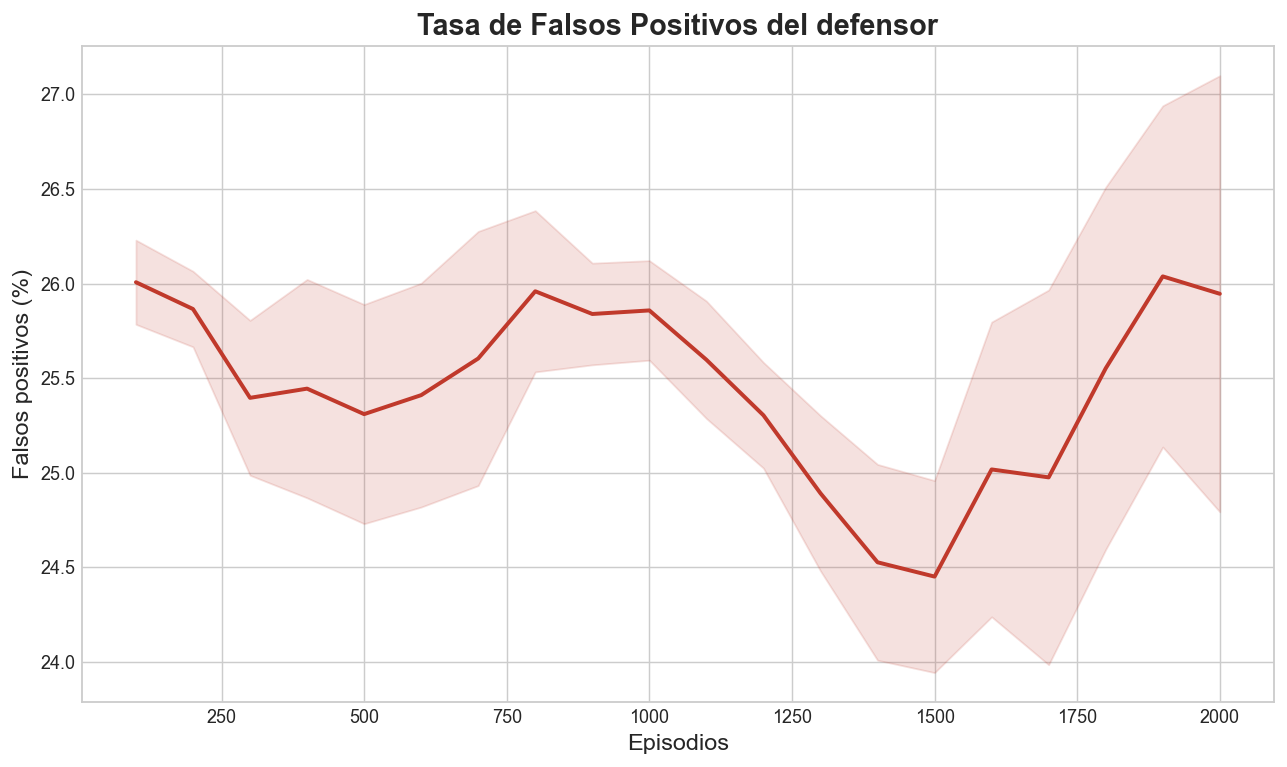

In [ ]:
# Tasa de falsos positivos (FPR)
false_positive_rate = np.array(defender_callback.history_false_positive_rate) * 100  # en %

# Suavizado
window = 5
smooth_fpr = uniform_filter1d(false_positive_rate, size=window)

# Desviación estándar local
std_fpr = uniform_filter1d(np.abs(false_positive_rate - smooth_fpr), size=window)

# Configuración del gráfico
plt.figure(figsize=(10, 6), dpi=130)

# Línea suavizada
plt.plot(episodes, smooth_fpr, linewidth=2.2, color="#c0392b")

# Banda difuminada
plt.fill_between(
    episodes,
    smooth_fpr - std_fpr,
    smooth_fpr + std_fpr,
    color="#c0392b",
    alpha=0.15
)

plt.title("Tasa de Falsos Positivos del defensor", fontsize=16, fontweight="bold")
plt.xlabel("Episodios", fontsize=13)
plt.ylabel("Falsos positivos (%)", fontsize=13)
plt.tight_layout()
plt.show()

Evaluaciones PPO Defender

In [ ]:
# Creamos el entorno vectorizado para evaluación
venv_def = DummyVecEnv([make_defender_env])  # ya lo tienes creado

# Desactivamos el aprendizaje
venv_def.training = False
venv_def.norm_reward = False

# Cargamos el modelo del defensor entrenado
model_defender = PPO.load("../../agents/v2/ppo_defender_threshold")

# Evaluamos el defensor con 300 episodios
det_rate, fpr, mean_reward, mean_th, mean_p = evaluate_defender(model_defender, venv_def, n_episodes=300)

# Sacamos los resultados por consola
print(f"Tasa de detección (TPR):           {det_rate*100:.3f}%") # De todos los ataques, cuántos detecta
print(f"Tasa de falsos positivos (FPR):    {fpr*100:.3f}%") # De todos los normales, cuántos clasifica mal como ataques
print(f"Reward medio por paso:            {mean_reward:.3f}")
print(f"Threshold medio:                  {mean_th:.3f}")
print(f"Probabilidad media de ataque:     {mean_p:.3f}") # Probabilidad media de que las muestras sean ataques según el clasificador

Tasa de detección (TPR):           26.939%
Tasa de falsos positivos (FPR):    26.807%
Reward medio por paso:            0.397
Threshold medio:                  0.382
Probabilidad media de ataque:     0.253
